# Classification 

In this notebook, we would try to tackle the classification problem. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_curve, f1_score

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from glmnet import LogitNet
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings("ignore")


## Data preparation

We first split the data to train and test. The test data is all the data we have for June 1st. Then, we add features that we found in the data visualization. Then we standarize the data. Finally, we add some absolute values of the features since we observed the behaviour of arrivals are different for some features when the features are positive or negative. We also shifted the features by 1 2 and 5 time slots so that the prediction will be made according to the past time points.

We standarize our data by robust scalar where the median of the columns are subtracted and the 25% to 75% quantiles are used as the spread. We would also need to impute the NaNs either from the data or from the shift we did for the data. 

In [2]:

data = pd.read_csv("data.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace = True)
data = data.sort_index()

data["Bid Arrival"] = np.round(data["Bid Arrival"])
data["Ask Arrival"] = np.round(data["Ask Arrival"])

data["Bid Arr Pred"] = data["Bid Arrival"].shift(-1)
data["Ask Arr Pred"] = data["Ask Arrival"].shift(-1)

test_data = data[data.columns]
train_data = data[data.columns]

test_data = data.loc[data.index.floor("D") == pd.Timestamp('2017-06-01 00:00:00')]
train_data = data.loc[data.index.floor("D") != pd.Timestamp('2017-06-01 00:00:00')]

train_data = train_data.sort_index()
test_data = test_data.sort_index()

train_data = train_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

def add_features(data):

    data["diff Volume"] =data["Volume"].shift(-1) - data["Volume"]
    data["diff Turnover"] = data["Turnover"].shift(-1) - data["Turnover"]
    data["Mean Px Taken"] = (data["diff Turnover"]/data["diff Volume"]).fillna(method="ffill")
    data["Median Px"] = (data["Bid Px"] + data["Ask Px"])*0.5
    data["Median Px"] = data["Median Px"].fillna(method="ffill")
    data["diff Median Px"] = data["Median Px"].shift(-1) - data["Median Px"]
    data["diff Mean Px"] =  data["Mean Px Taken"].shift(-1) - data["Mean Px Taken"]
    data["diff Bid Px"] =  data["Bid Px"].shift(-1) - data["Bid Px"]
    data["diff Ask Px"] = data["Ask Px"].shift(-1) - data["Ask Px"] 

    data["log mean return"] = np.log(data["Median Px"].shift(-1)) - np.log(data["Median Px"]) 
    data["log mean return"] = data["log mean return"].fillna(method="ffill")


    data["imbalance"] = data["Bid Vol"] - data["Ask Vol"]

    data["Px gap"] = (data["Ask Px"] - data["Bid Px"])/data["Median Px"]

    data["Bid active"] = data["Bid Arrival"] - data["Bid Retreat"] - data["Bid Taken"]
    data["Ask active"] = data["Ask Arrival"] - data["Ask Retreat"] - data["Ask Taken"]


    data["volatile"] = data["log mean return"].rolling(5*30).std() # 30 = 1 mins
    data["volatile"] = data["volatile"].fillna(method="ffill")

    data["Last Px - Median Px"] = data["Last Px"] - data["Median Px"]

    
    data["Time from Open"] = (data.index - data.index.floor("D") ).astype('timedelta64[s]')
        
    return data  
        
def add_abs_features(data):    
    data["abs(Last Px - Median Px)"] = np.absolute(data["Last Px - Median Px"])
    data["abs diff Median Px"] = np.absolute(data["diff Median Px"])
    data["abs diff Mean Px"] = np.absolute(data["diff Mean Px"])
    data["abs diff Bid Px"] =  np.absolute(data["diff Bid Px"])
    data["abs diff Ask Px"] = np.absolute(data["diff Ask Px"])
    data["abs Bid active"] = np.absolute(data["Bid active"])
    data["abs Ask active"] = np.absolute(data["Ask active"])
    data["abs log mean return"] = np.absolute(data["log mean return"])

    return data
    
def add_shifted_features(data):
    columns = data.columns.drop(["Ask Arr Pred", "Bid Arr Pred"])
    delays = [1,2,5]
    for delay in delays:
        for c in columns:
            if ("diff " + c in columns) and delay == 1:
                continue
            data["d_"+str(delay)+"_"+c] = data[c].shift(delay)
            
    return data

    
test_data = add_features(test_data)
train_data = add_features(train_data)

test_data_original  = test_data.copy()
train_data_original = train_data.copy()

imputer = SimpleImputer()
scaler = RobustScaler()

trainX = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
testX = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])

trainX_imputed = imputer.fit(trainX).transform(trainX)
testX_imputed = imputer.transform(testX)

trainX_scaled = scaler.fit(trainX_imputed).transform(trainX_imputed)
testX_scaled = scaler.transform(testX_imputed)

train_data[trainX.columns] = trainX_scaled
test_data[testX.columns] = testX_scaled

train_data = add_abs_features(train_data)
test_data = add_abs_features(test_data)

train_data = add_shifted_features(train_data)
test_data = add_shifted_features(test_data)

# Impute nans for shifted values
imputer = SimpleImputer()
trainX = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
testX = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
trainX_imputed = imputer.fit(trainX).transform(trainX)
testX_imputed = imputer.transform(testX)
train_data[trainX.columns] = trainX_imputed
test_data[testX.columns] = testX_imputed


In [3]:
X = train_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
y1 = train_data["Bid Arr Pred"]
y2 = train_data["Ask Arr Pred"]


X_test = test_data.drop(columns = ["Bid Arr Pred", "Ask Arr Pred"])
y1_test = test_data["Bid Arr Pred"]
y2_test = test_data["Ask Arr Pred"]

In [4]:
def plotROC(target, pred):
    plt.show()
    fpr1, tpr1, t1 = roc_curve(target, pred)
    plt.plot(fpr1, tpr1)
    plt.plot(fpr1,fpr1)
    
    plt.show()
    AUC = auc(fpr1, tpr1)
    print ("AUC:", AUC)
    return AUC

## Using Lasso to Select Parameters

From the below plots and the final coefficients plot, it is clear, the features we added are too much for the model and thus we finally use a PCA to reduce dimension and get 50 features in the last. 

In [5]:
bid = LogitNet(scoring="roc_auc", n_splits = 5) #n_lambda = 100
bid = bid.fit(X, y1 >0)

ask = LogitNet(scoring="roc_auc", n_splits = 5)
ask = ask.fit(X, y2 >0)
print (ask.lambda_best_, bid.lambda_best_)

[0.0003046] [0.0028031]


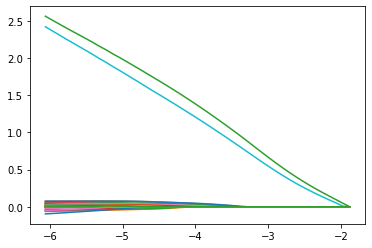

In [6]:
for i in range(bid.coef_path_.shape[1]):
    plt.plot(np.log(bid.lambda_path_), bid.coef_path_[0,i,:])

In [7]:
coef = pd.DataFrame({"Bid": bid.coef_[0], "Ask":ask.coef_[0]}, 
                    index = train_data.columns.drop(["Bid Arr Pred", "Ask Arr Pred"]))

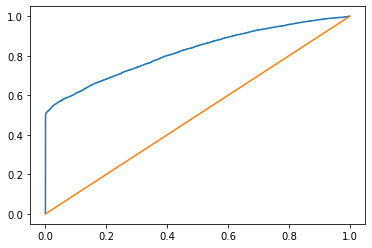

AUC: 0.8215695152593061


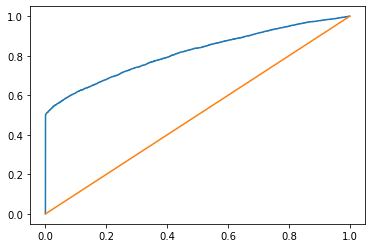

AUC: 0.8152183965705813


0.8152183965705813

In [8]:
y1_pred = bid.predict_proba(X_test)[:,1]
y2_pred = ask.predict_proba(X_test)[:,1]

plotROC(y1_test>0, y1_pred)
plotROC(y2_test>0, y2_pred)

In [9]:
print(
    np.mean((y1_pred > 0.5) == (y1_test>0.0)),
    np.mean((y2_pred > 0.5) == (y2_test>0.0))
)

0.8116764863417247 0.8115158007498661


In [10]:
print(
    f1_score(y1_test > 0.0, y1_pred > 0.5),
    f1_score(y2_test > 0.0, y2_pred > 0.5)
)

0.6757055893746542 0.6730465483601226


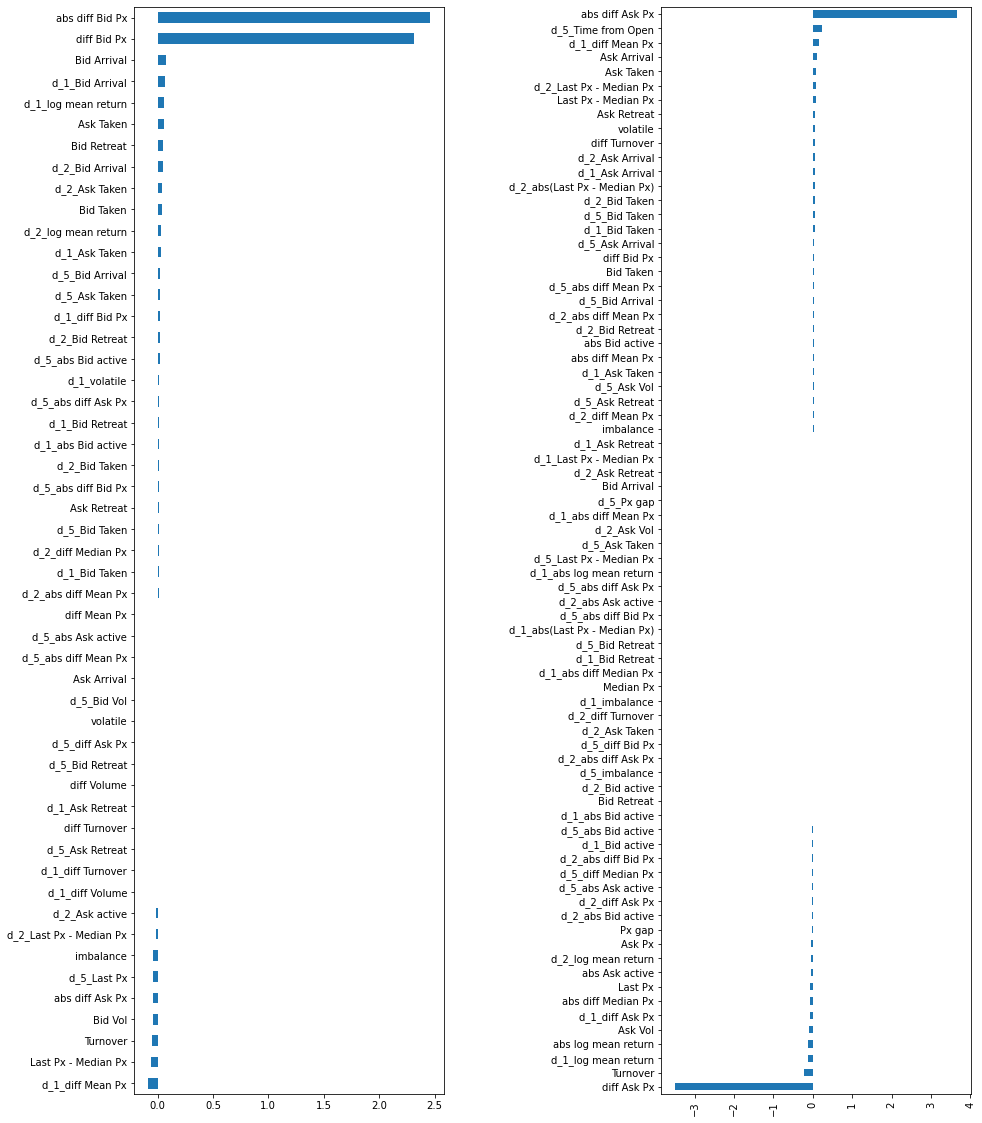

In [11]:
plt.figure(figsize = (25,20))
ax = plt.subplot(121)
coef[coef["Bid"] !=0].sort_values("Bid")["Bid"].plot(kind="barh",figsize=(10,20), ax = ax)
ax = plt.subplot(122)
coef[coef["Ask"] !=0].sort_values("Ask")["Ask"].plot(kind="barh",figsize=(15,20), ax = ax)
plt.xticks(rotation=90)
plt.subplots_adjust(wspace = 0.7)
plt.show()

In [12]:
print("Bid nonzero coef: ", np.sum(coef["Bid"] !=0))
print("Ask nonzero coef: ", np.sum(coef["Ask"] !=0))
print("Bid or Ask use:  ",np.sum(np.logical_or(coef["Ask"] !=0 
                                        ,coef["Bid"] !=0 ) ) )
print("both use:", np.sum(np.logical_and(coef["Ask"] !=0 
                                        ,coef["Bid"] !=0 ) ) )

print("total availabe:", coef.shape[0])

Bid nonzero coef:  51
Ask nonzero coef:  76
Bid or Ask use:   91
both use: 36
total availabe: 143


In [14]:
both_used_features = list(coef.index[np.logical_or(coef["Ask"] !=0,coef["Bid"] !=0 )])

**Here, we see bid model uses less parameter since the Lasso regression returns a larger $\lambda$ value for the penalty.**

## PCA transform

We first select the parameters that are all needed for both ask and bid and then we use full PCA to get the explained variance plot and we find there is long platau and thus we should select $80$ degress of components as our input features

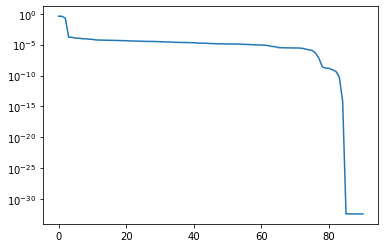

In [13]:
both_used_features = list(coef.index[np.logical_or(coef["Ask"] !=0,coef["Bid"] !=0 )])
X = train_data[both_used_features]
X_test = test_data[both_used_features]

pca = PCA(n_components = 91)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_)
plt.yscale("log")
plt.show()

In [14]:
pca = PCA(n_components = 80)
X_pca = pca.fit(X).transform(X)
X_test_pca = pca.transform(X_test)

## Select Models 

we would first use the following models and try to filter out some good models. 

  - Logistic
  - K-nearest neighbors
  - Gradient Boost
  - XgBoost
  - ExtraTree
  - SVC linear
  - Decision Tree
  - Random Forest
  - AdaBoost
  - NaiveBayes
  - Quadratic Discrimnant Analysis
  

In [15]:
def class_cv(model,X,y, scoring = "f1"):
    
    score = cross_val_score(model, X, y, scoring= scoring, cv=5)
    
    return score

class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid, cv=5, scoring="f1")
        grid_search.fit(X,y)
        print(grid_search.best_params_, grid_search.best_score_)
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

### Selection models for Bid Arrivals

We will first use the PCA output of the transformed inputs to select good models using the score of f1 since f1 socre will be more sensitive to the behaviour of the models. Although, in case we care more about the predictibility of the model (i.e. the probability it estimates for non-zero order arrivals), we should use the AUC score to select the model, the f1 score is more suitable for unbalanced data. Our data is unbalanced and we want more contrast over the behaviour of different models, we will select **f1** socre as our selection rule. 

In [16]:
bid_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    KNeighborsClassifier(n_neighbors = 10, algorithm = "kd_tree"),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=20),
    ExtraTreesClassifier(n_estimators = 50),
    LinearSVC(C = 0.1, max_iter = 5000),
    DecisionTreeClassifier(max_depth = 6),
    RandomForestClassifier(max_depth = 4, n_estimators = 20),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=20),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]

bid_models_names = [
    "Logit",
    "KNN",
    "GBoost",
    "xgboost",
    "ExTree",
    "linear_SVC",
    "DTree",
    "Forest",
    "AdaBoost",
    "NaiveBayes",
    "QDA"
]

In [17]:
for name, model in zip(bid_models_names, bid_models_PCA):
    score = class_cv(model, X_pca, y1>0)
    auc_score = class_cv(model, X_pca, y1>0, "roc_auc")
    print("{}: {:.6f}, {:.4f}, {:.6f}".format(name,score.mean(),score.std(), auc_score.mean() ))

Logit: 0.710906, 0.0120, 0.827174
KNN: 0.455910, 0.0256, 0.722490
GBoost: 0.666341, 0.0120, 0.808919
xgboost: 0.676690, 0.0120, 0.812127
ExTree: 0.602243, 0.0210, 0.783058
linear_SVC: 0.707485, 0.0123, 0.826399
DTree: 0.562056, 0.0206, 0.739678
Forest: 0.444868, 0.0378, 0.752230
AdaBoost: 0.644987, 0.0084, 0.779129
NaiveBayes: 0.368621, 0.0662, 0.649503
QDA: 0.694327, 0.0134, 0.799536


Since the dimension of the input variables is too big for the KNN given the number of data points in the data set, the behaviour of KNN is very bad and we should reject it. Similar for the NaiveBayes and we would not use it. For the random forest and Decision tree, we did not see great performance. This may be because we used too shallow trees. Then we will consider adjusting some hyperparameters to get a better model. The models we select are 

 - Logistic Regression
 - Gradinet Boost
 - XgBoost
 - Linear SVC
 - Decision Tree
 - AdaBoost
 - Quadratic Discrimnant Analysis
 
we may also try random forest for more trees
 
 - Randome Forest (More Trees)


In [19]:
print("Logit")
param_grid={'C':[100.0, 10.0, 1.0, 0.01,] }
grid(LogisticRegression(max_iter=1000, solver="lbfgs")).grid_get(X_pca,y1>0,param_grid)

print ("XGBClassifier")
param_grid={'n_estimators':[10, 50, 100, 150]}
grid(XGBClassifier()).grid_get(X_pca,y1>0,param_grid)

print("LinearSVC")
param_grid={'C':[10.0, 1.0, 0.01, 0.001]}
grid(LinearSVC(max_iter = 5000)).grid_get(X_pca,y1>0,param_grid)

print ("DTree")
param_grid={'max_depth':[5, 10, 15, 20]}
grid(DecisionTreeClassifier()).grid_get(X_pca,y1>0,param_grid)

print("AdaBoost 2")
param_grid={'n_estimators':[10, 50, 70, 100] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) )).grid_get(X_pca,y1>0,param_grid)

print("AdaBoost 4")
param_grid={'n_estimators':[10, 40, 50, 70] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4) )).grid_get(X_pca,y1>0,param_grid)

print("QDA")
param_grid={'reg_param':[1.0, 0.1, 0.001] }
grid(QuadraticDiscriminantAnalysis()).grid_get(X_pca,y1>0,param_grid)

print ("Random Forest")
param_grid={'max_depth':[2, 6, 8, 12], "n_estimators":[50, 100, 150]}
grid(RandomForestClassifier()).grid_get(X_pca,y1>0,param_grid)



Logit
{'C': 1.0} 0.7106912064705749
         params  mean_test_score  std_test_score
0  {'C': 100.0}         0.709647        0.011595
1   {'C': 10.0}         0.709795        0.011487
2    {'C': 1.0}         0.710691        0.011588
3   {'C': 0.01}         0.710448        0.012654
XGBClassifier
{'n_estimators': 150} 0.7007858527583632
                  params  mean_test_score  std_test_score
0   {'n_estimators': 10}         0.648285        0.014045
1   {'n_estimators': 50}         0.696731        0.010620
2  {'n_estimators': 100}         0.700029        0.011879
3  {'n_estimators': 150}         0.700786        0.012745
LinearSVC
{'C': 0.01} 0.7074429830541514
         params  mean_test_score  std_test_score
0   {'C': 10.0}         0.703570        0.013117
1    {'C': 1.0}         0.706737        0.012181
2   {'C': 0.01}         0.707443        0.012699
3  {'C': 0.001}         0.706890        0.013100
DTree
{'max_depth': 15} 0.6001937616186349
              params  mean_test_score  std_te

### Selection models for Ask Arrivals

We will use the same starting models to train on the ask outputs and select some of them to make our final models. However, as we find the KNN could not deal with the high dimension by the curse of dimensionality, we will omit the KNN and use the rest of the models. Then for the Random Forest, we will use more trees than before. 

In [20]:
ask_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=20),
    ExtraTreesClassifier(n_estimators = 50),
    LinearSVC(C = 0.1, max_iter = 5000),
    DecisionTreeClassifier(max_depth = 6),
    RandomForestClassifier(max_depth = 4, n_estimators = 50),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=20),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]

ask_models_names = [
    "Logit",
    "GBoost",
    "xgboost",
    "ExTree",
    "linear_SVC",
    "DTree",
    "Forest",
    "AdaBoost",
    "NaiveBayes",
    "QDA"
]

In [21]:
for name, model in zip(ask_models_names, ask_models_PCA):
    score = class_cv(model, X_pca, y2>0)
    auc_score = class_cv(model, X_pca, y2>0, "roc_auc")
    print("{}: {:.6f}, {:.4f}, {:.6f}".format(name,score.mean(),score.std(), auc_score.mean() ))

Logit: 0.712418, 0.0144, 0.831176
GBoost: 0.655616, 0.0163, 0.808611
xgboost: 0.669633, 0.0168, 0.813071
ExTree: 0.593792, 0.0189, 0.784600
linear_SVC: 0.708655, 0.0159, 0.830418
DTree: 0.531418, 0.0245, 0.734838
Forest: 0.401859, 0.0337, 0.755924
AdaBoost: 0.641176, 0.0122, 0.780454
NaiveBayes: 0.354459, 0.0624, 0.640916
QDA: 0.691352, 0.0170, 0.799244


Then we will consider adjusting some hyperparameters to get a better model. The models we select are 

 - Logistic Regression
 - Gradinet Boost
 - XgBoost
 - Linear SVC
 - AdaBoost
 - Quadratic Discrimnant Analysis
 
 Then we will fine tune the hyper parameter to make the classification more powerful 


In [22]:
print("Logit")
param_grid={'C':[1000.0, 10.0, 1.0, 0.01, 0.001] }
grid(LogisticRegression(max_iter=1000, solver="lbfgs")).grid_get(X_pca,y2>0,param_grid)

print ("XGBClassifier")
param_grid={'n_estimators':[10, 50, 100, 150]}
grid(XGBClassifier()).grid_get(X_pca,y2>0,param_grid)

print("LinearSVC")
param_grid={'C':[10.0, 1.0, 0.01, 0.001]}
grid(LinearSVC(max_iter = 5000)).grid_get(X_pca,y2>0,param_grid)

print("AdaBoost 2")
param_grid={'n_estimators':[10, 50, 70, 100] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2) )).grid_get(X_pca,y2>0,param_grid)

print("AdaBoost 4")
param_grid={'n_estimators':[10, 50, 70, 100] }
grid(AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4) )).grid_get(X_pca,y2>0,param_grid)

print("QDA")
param_grid={'reg_param':[1.0, 0.1 , 0.01, 0.001] }
grid(QuadraticDiscriminantAnalysis()).grid_get(X_pca,y2>0,param_grid)



Logit
{'C': 1.0} 0.7126346058923597
          params  mean_test_score  std_test_score
0  {'C': 1000.0}         0.712180        0.014230
1    {'C': 10.0}         0.712177        0.014203
2     {'C': 1.0}         0.712635        0.014349
3    {'C': 0.01}         0.711435        0.014471
4   {'C': 0.001}         0.709309        0.016035
XGBClassifier
{'n_estimators': 150} 0.7008152421156656
                  params  mean_test_score  std_test_score
0   {'n_estimators': 10}         0.637027        0.016191
1   {'n_estimators': 50}         0.694075        0.016804
2  {'n_estimators': 100}         0.700721        0.017191
3  {'n_estimators': 150}         0.700815        0.015207
LinearSVC
{'C': 1.0} 0.708654229850091
         params  mean_test_score  std_test_score
0   {'C': 10.0}         0.705139        0.018101
1    {'C': 1.0}         0.708654        0.015758
2   {'C': 0.01}         0.708216        0.015836
3  {'C': 0.001}         0.707308        0.015708
AdaBoost 2
{'n_estimators': 100} 0.

## Stacking the Models for the classification

We first append the deep net results to the data since we would like to train the meta classifier in the second stack of our stack with the inputs from the deep Nets. 


In [23]:
from DeepNets.train import load_and_evaluate

bid_path = "./DeepNets/output/bid_CNN.pth"
ask_path = "./DeepNets/output/ask_CNN.pth"

train_data_deep = load_and_evaluate([bid_path, ask_path], train_data_original)
test_data_deep  = load_and_evaluate([bid_path, ask_path], test_data_original )

train_data_deep = train_data_deep.to_numpy()
test_data_deep  = test_data_deep.to_numpy()


          bid_model  ask_model
loss       0.929859   0.934484
AUC        0.600382   0.596562
f1_score   0.232832   0.230310
accuracy   0.629217   0.631310
          bid_model  ask_model
loss       0.952738   0.940312
AUC        0.593745   0.597436
f1_score   0.188773   0.181796
accuracy   0.642474   0.638369


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)

    def fit(self,X,y, append = None):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))

        for i,model in enumerate(self.mod):
            print ("training for " + str(i) + " out of " + str(len(self.mod)))
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                if (type(model).__name__ == 'LinearSVC'):
                    oof_train[val_index,i] = renew_model.predict(X[val_index])
                else:
                    oof_train[val_index,i] = renew_model.predict_proba(X[val_index])[:,1]
        if not (append is None):
            oof_train = np.hstack([oof_train, append])
        oof_train = np.hstack([X,oof_train])
        self.meta_model.fit(oof_train,y)
        return self

    def predict(self,X, append= None):
        whole_test = np.column_stack([
                np.column_stack(
                    [model.predict_proba(X)[:,1] for model in single_model]
                ).mean(axis=1) 
            if (type(single_model[0]).__name__ != 'LinearSVC')
            else 
                np.column_stack(
                    [model.predict(X) for model in single_model]
                ).mean(axis=1) 
            for single_model in self.saved_model
        ])
        if not (append is None):
            whole_test = np.hstack([whole_test,append])
        whole_test = np.hstack([X,whole_test])
        return self.meta_model.predict_proba(whole_test)[:,1]

    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [38]:
bid_models_PCA = [
    LogisticRegression(C = 0.1, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=150),
    LinearSVC(C = 0.1, max_iter = 5000),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=100),
    QuadraticDiscriminantAnalysis(reg_param=0.01)
]
Base_model = LogisticRegression(C = 0.1, solver = 'lbfgs')
bidstack = stacking(bid_models_PCA, Base_model)
bidstack = bidstack.fit(X_pca, y1 > 0, train_data_deep)

training for 0 out of 6
training for 1 out of 6
training for 2 out of 6
training for 3 out of 6
training for 4 out of 6
training for 5 out of 6


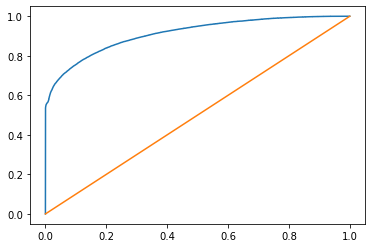

AUC: 0.9111306771504235
f1_score:  0.7504561596264395
accuracy:  0.838017855096089


In [39]:
bid_pred = bidstack.predict(X_pca, train_data_deep)
plotROC(y1>0, bid_pred)
print("f1_score: ", f1_score(y1 > 0.0, bid_pred > 0.5) )
print("accuracy: ", np.mean( (y1>0.0)==(bid_pred > 0.5) ) )


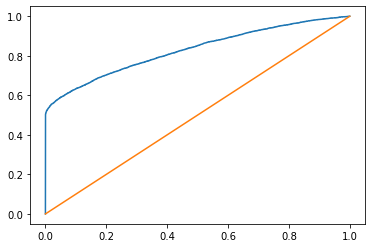

AUC: 0.8283633633361773
BID TEST SCORE: 
f1_score:  0.6989999114965927
accuracy:  0.8178361006963042


In [40]:
bid_test_pred = bidstack.predict(X_test_pca, test_data_deep)
plotROC(y1_test>0, bid_test_pred)
print("BID TEST SCORE: ")
print("f1_score: ", f1_score(y1_test > 0.0, bid_test_pred > 0.5) )
print("accuracy: ", np.mean( (y1_test>0.0)==(bid_test_pred > 0.5) ) )

In [43]:
ask_models_PCA = [
    LogisticRegression(C = 1.0, solver = 'lbfgs'),
    GradientBoostingClassifier(),
    XGBClassifier(n_estimators=150),
    LinearSVC(C = 0.1, max_iter = 5000),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), n_estimators=100),
    QuadraticDiscriminantAnalysis(reg_param=0.001)
]
Base_model = LogisticRegression(C = 0.1, solver = 'lbfgs')
askstack = stacking(ask_models_PCA, Base_model )
askstack = askstack.fit(X_pca, y2 > 0, train_data_deep)

training for 0 out of 6
training for 1 out of 6
training for 2 out of 6
training for 3 out of 6
training for 4 out of 6
training for 5 out of 6


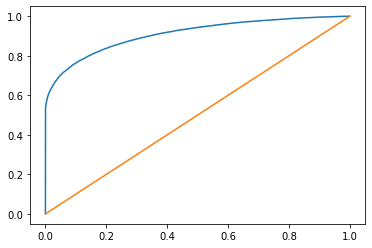

AUC: 0.9084832852451128
f1_score:  0.7457579299504251
accuracy:  0.8393296060926376


In [44]:
ask_pred = askstack.predict(X_pca, train_data_deep)
plotROC(y2>0, ask_pred)
print("f1_score: ", f1_score(y2 > 0.0, ask_pred > 0.5) )
print("accuracy: ", np.mean( (y2 >0.0)==(ask_pred > 0.5) ) )

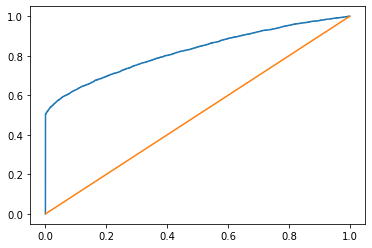

AUC: 0.8231403202441435
BID TEST SCORE: 
f1_score:  0.6843162315136023
accuracy:  0.8147830744509909


In [46]:
ask_test_pred = askstack.predict(X_test_pca, test_data_deep)
plotROC(y2_test>0, ask_test_pred)
print("BID TEST SCORE: ")
print("f1_score: ", f1_score(y2_test > 0.0, ask_test_pred > 0.5) )
print("accuracy: ", np.mean( (y2_test>0.0)==(ask_test_pred > 0.5) ) )

## Conclusion:

We achieved accuracy for both Bid and Ask orders as:

 - Bid Order Arrivals: 81.78%
 - Ask Order Arrivals: 81.48%



In [48]:
np.savez("class.npz", 
         train_deep  = train_data_deep,
         test_deep   = test_data_deep,
         train_stack = np.vstack([bid_pred, ask_pred]),
         test_stack  = np.vstack([bid_test_pred , ask_test_pred ])
        )